In [3]:

import numpy as np
import pysal as ps
import random as rdm
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
import geojson as gj

from pylab import rcParams
rcParams['figure.figsize'] = 20,20

from database_manager import DatabaseManager
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

ImportError: dlopen(/Users/jonathanmagiera/anaconda3/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libuuid.1.dylib
  Referenced from: /Users/jonathanmagiera/anaconda3/lib/libgdal.20.dylib
  Reason: image not found

In [1]:
NUM_ZIPS = 404

def create_connection():
    conn = DatabaseManager.get_connection()
    cursor = conn.cursor(buffered=True)
    return conn, cursor

def close_connection(conn, cursor):
    cursor.close()
    conn.close()
    
NUM_ZIPS = 287

############################################
# CHANGE THIS WHEN YOU ADD/REMOVE FEATURES #
############################################
NUM_FEATURES = 12

def create_connection():
    conn = DatabaseManager.get_connection()
    cursor = conn.cursor(buffered=True)
    return conn, cursor

def close_connection(conn, cursor):
    cursor.close()
    conn.close()
    
## Pulls in the demographic features 
def get_demographics(conn, cursor):
    feature_dict = {}
    cursor.execute("SELECT zip_id, personal_vehicle, carpool, public_transportation, taxi, motorcycle, walking, bicycle FROM transportation_method, zip WHERE transportation_method.zip_id=zip.id")
    rows = cursor.fetchall()
    list_ind = 0
    
    for row in rows:
        for ind, val in enumerate(row):
            if row[0] not in feature_dict:
                feature_dict[row[0]] = np.zeros(12)
            if ind > 0:
                feature_dict[row[0]][ind-1] = val
        
    list_ind = ind
    
    cursor.execute("SELECT zip_id, recipient_count FROM food_stamps, zip WHERE food_stamps.zip_id=zip.id")
    rows = cursor.fetchall()
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
        
    cursor.execute("SELECT zip_id, median_income FROM median_income, zip WHERE median_income.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
        
    cursor.execute("SELECT zip_id, population FROM total_population, zip WHERE total_population.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    cursor.execute("SELECT zip_id, family_households, nonfamily_households FROM relationships, zip WHERE relationships.zip_id=zip.id;")
    rows = cursor.fetchall()    
    
    for row in rows:
        for ind, val in enumerate(row):
            if ind > 0:
                feature_dict[row[0]][ind+list_ind-1] = val
          
    list_ind = list_ind + ind
    
    return feature_dict

Import data

Import ACS data from csv, set geoid as the index, and drop non-included variables

[]

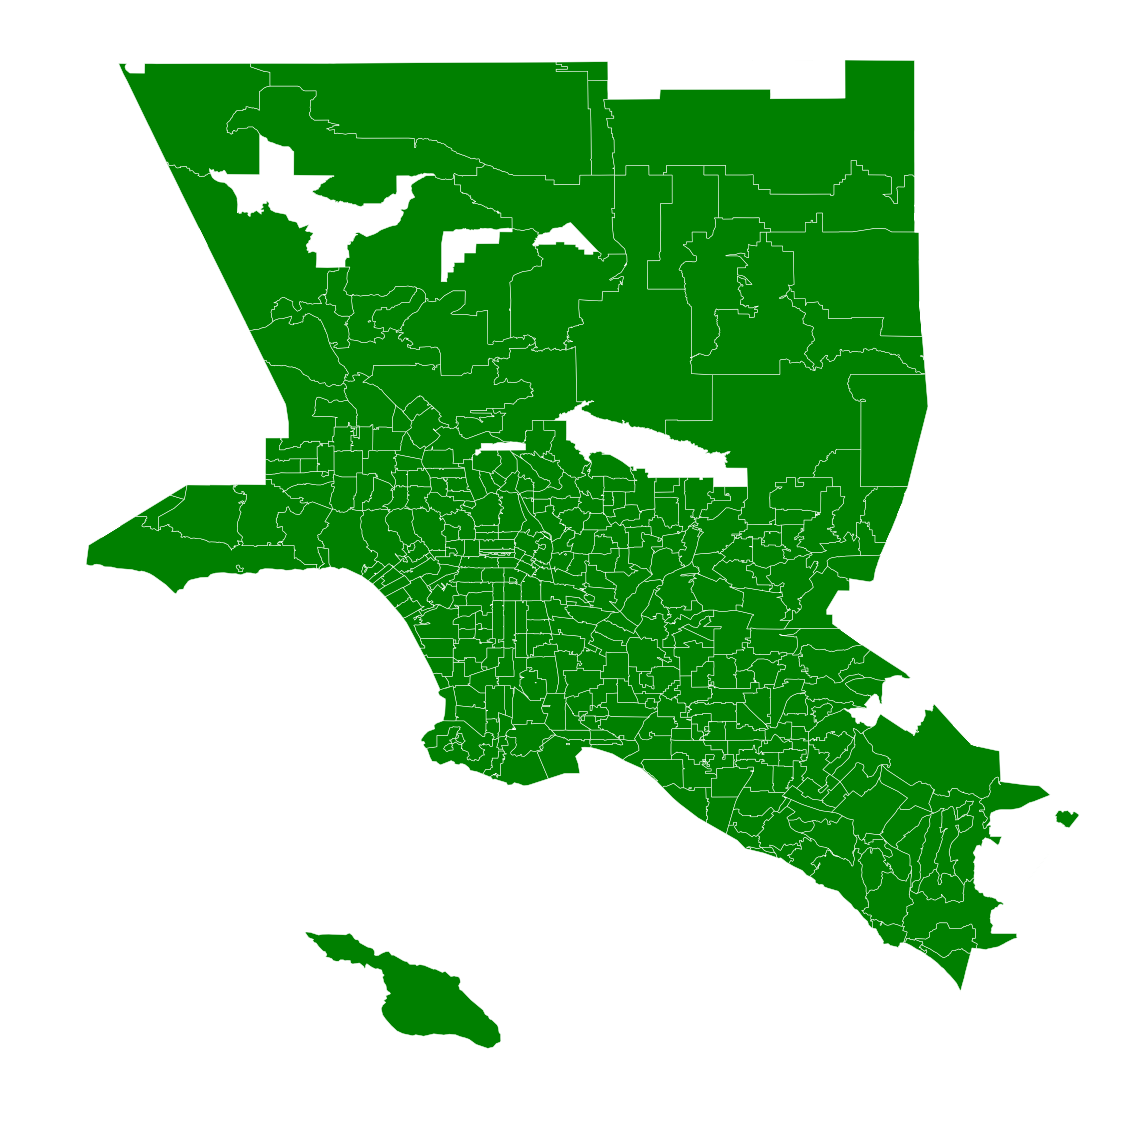

In [24]:
la_geog = gpd.read_file('la_zips/la_zips.shp')
la_geog['constant'] = 1
p = la_geog.plot(color='green', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()

In [36]:
la_zips_data = ps.pdio.read_files('la_zips/la_zips.shp')
print(la_zips_data.head())
#print(la_zips_data.shape)
la_zips = list(la_zips_data.ZCTA5CE10)
la_zips = [ int(x) for x in la_zips ]
print(la_zips)
print(len(la_zips))
print(len(set(la_zips)))

  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10 CSAFP CBSAFP  \
0     90401  8600000US90401   90401    2199165    439378   348  31080   
1     93534  8600000US93534   93534   45949584   1026721   348  31080   
2     91306  8600000US91306   91306   10718169     63094   348  31080   
3     93560  8600000US93560   93560  413254265    663206   348  31080   
4     90008  8600000US90008   90008    9513272     68544   348  31080   

         AFFGEOID  GEOID                                NAME LSAD  \
0  310M300US31080  31080  Los Angeles-Long Beach-Anaheim, CA   M1   
1  310M300US31080  31080  Los Angeles-Long Beach-Anaheim, CA   M1   
2  310M300US31080  31080  Los Angeles-Long Beach-Anaheim, CA   M1   
3  310M300US31080  31080  Los Angeles-Long Beach-Anaheim, CA   M1   
4  310M300US31080  31080  Los Angeles-Long Beach-Anaheim, CA   M1   

         ALAND      AWATER                                          geometry  
0  12558980980  2201709418  <pysal.cg.shapes.Polygon object at 0x1a

In [2]:
## Create a connection to the db
conn, cursor = create_connection()

## Pull in the demographic features
feature_dict = get_demographics(conn, cursor)

## Feature_dict should be {zip_id: [list of x features]},
## so let's print out an example to make sure
print(feature_dict[19607])

## Create a readable feature-vector from the values using np
X = np.zeros((NUM_ZIPS, NUM_FEATURES))
for ind, (k,v) in enumerate(feature_dict.items()):
    X[ind] = v
 
close_connection(conn, cursor)

NameError: name 'DatabaseManager' is not defined

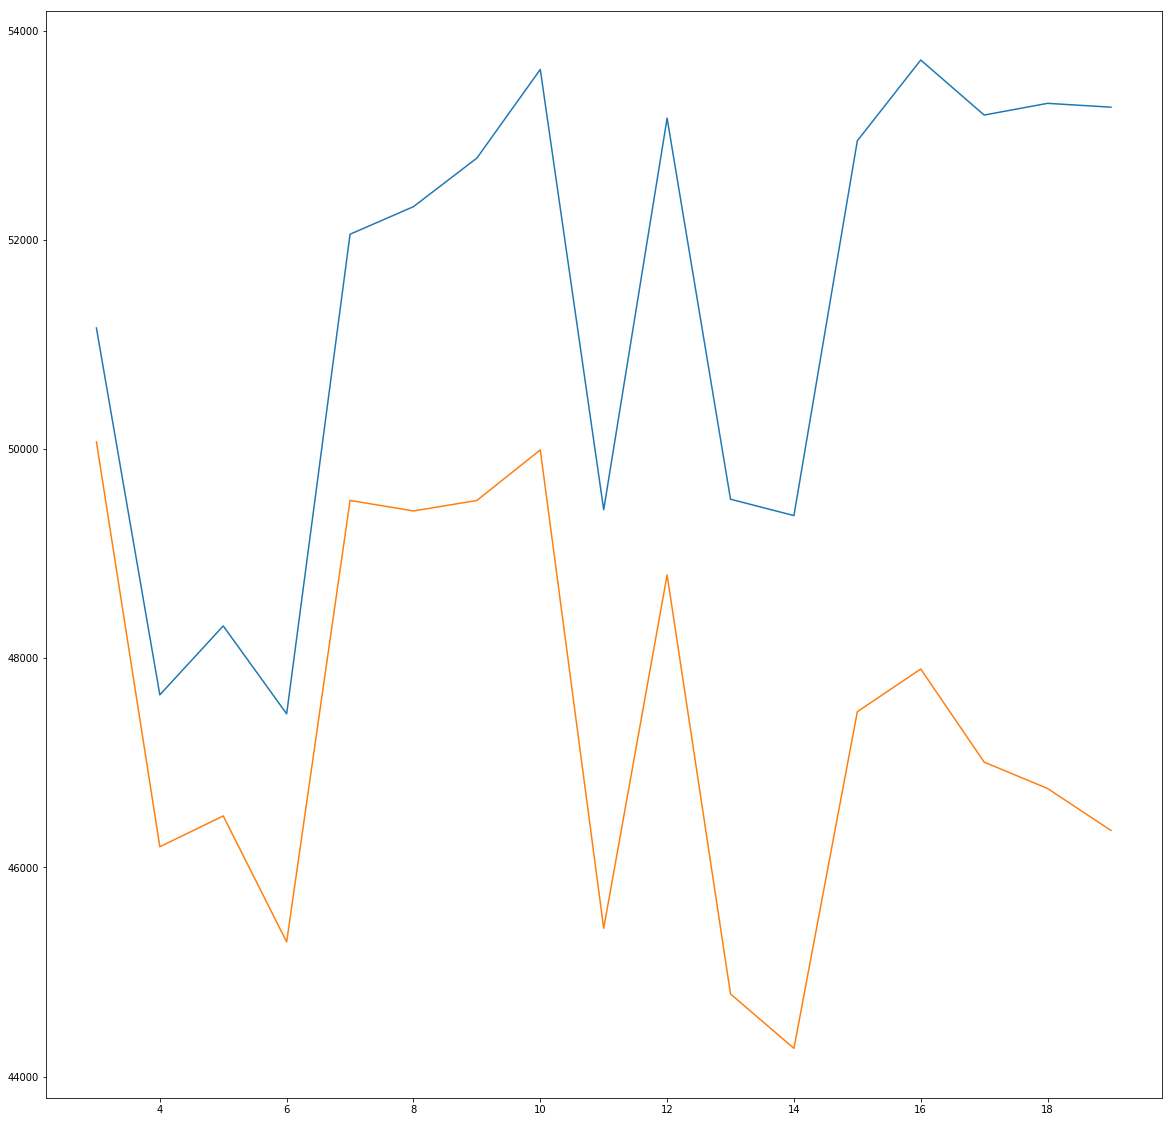

In [41]:
k_vals = np.arange(3, 20)
models = [GaussianMixture(k, random_state = 1234).fit(X) for k in k_vals]

plt.plot(k_vals, [m.bic(X) for m in models], label = 'BIC')
plt.plot(k_vals, [m.aic(X) for m in models], label = 'AIC')

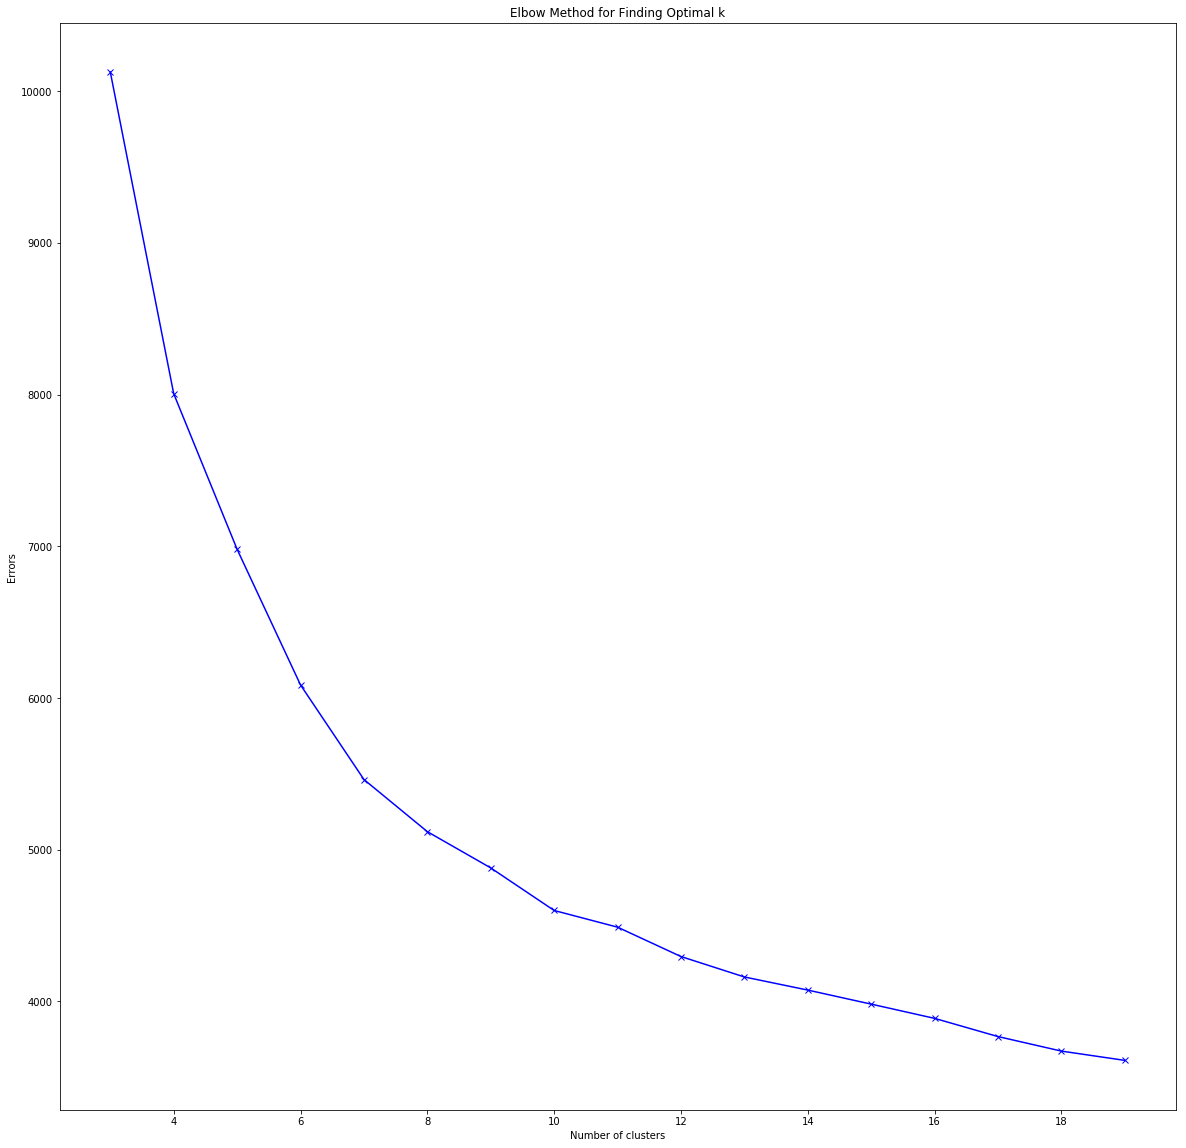

In [10]:
errors = []
k_vals = np.arange(3, 20)
for k in k_vals:
    kmeans_model = KMeans(n_clusters = k, init = 'k-means++').fit(X)
    errors.append(sum(np.min(cdist(X, kmeans_model.cluster_centers_, 'euclidean'), axis=1))/X.shape[0])
plt.plot(k_vals, errors, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Errors')
plt.title('Elbow Method for Finding Optimal k')
plt.show()

In [42]:
clusterer_k = KMeans(n_clusters=7, init = 'k-means++', random_state=1234)
cluster_labels_k = clusterer_k.fit_predict(X)
print(cluster_labels_k.size)

clusterer_GMM = GaussianMixture(12, random_state = 1234).fit(X)
cluster_labels_gmm = clusterer_GMM.predict(X)
print(cluster_labels_gmm.size)



404
404


[]

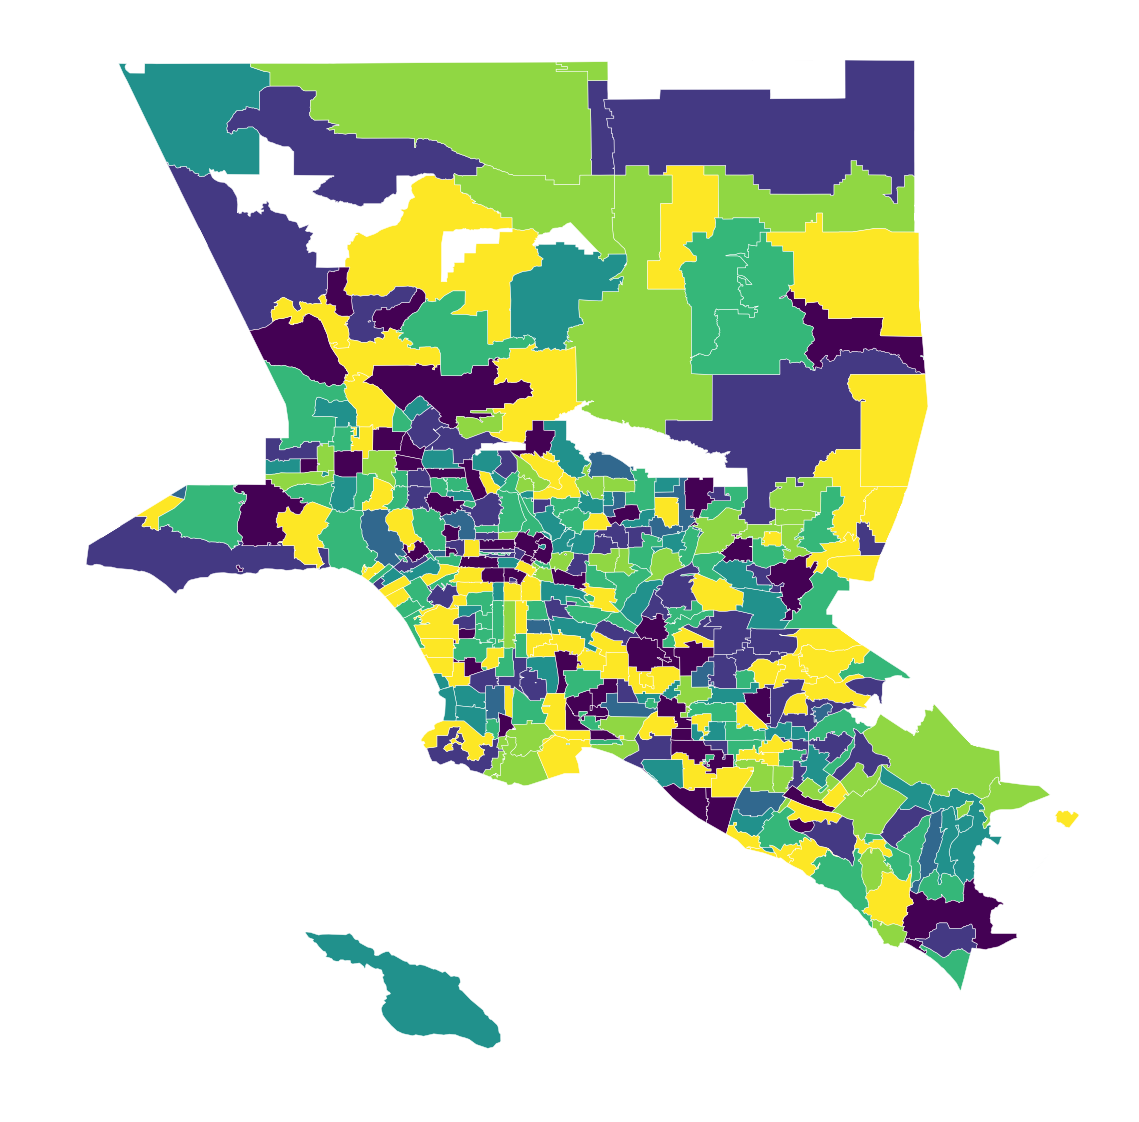

In [43]:
la_geog['cluster_k'] = cluster_labels_k
p = la_geog.plot(column='cluster_k', linewidth=0.5, edgecolor='white', legend=True)
p.axis('off')
p.plot()

[]

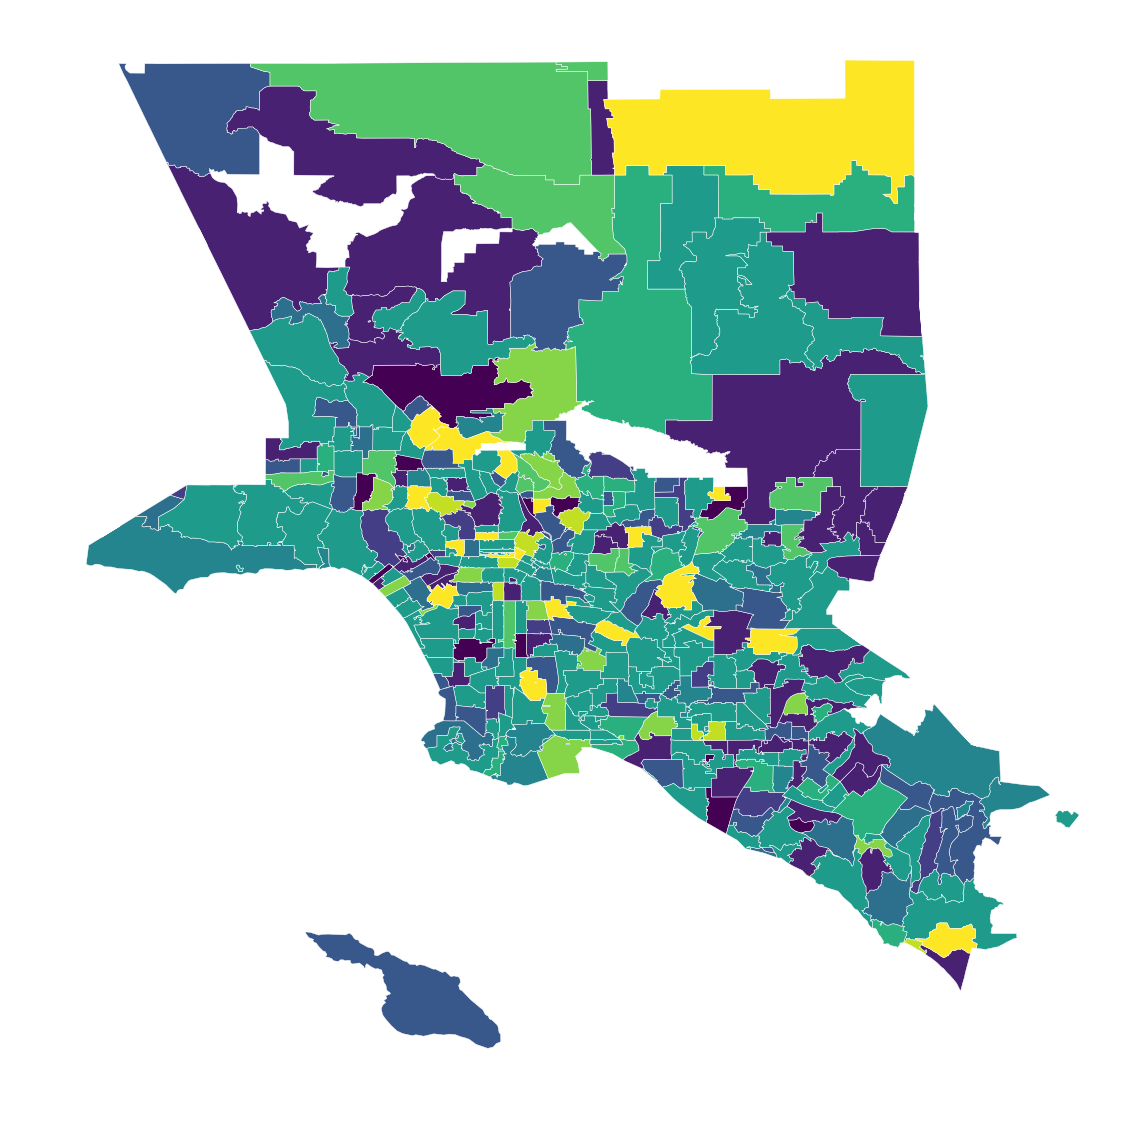

In [44]:
la_geog['cluster_gmm'] = cluster_labels_gmm
p = la_geog.plot(column='cluster_gmm', linewidth=0.5, edgecolor='white')
p.axis('off')
p.plot()